In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats.qmc import LatinHypercube
from scipy.stats import uniform, loguniform, norm, gaussian_kde
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D
import itertools  # Import the itertools module
import GPy
from scipy.spatial import ConvexHull, Voronoi
from datetime import datetime

# Guide and Ideas for Capstone Project - Function 7

Function 7: Sometimes Lazy is Best (6D)
You are now optimising six hyper-parameters of a machine learning model. Note that it is a popular and frequently used model, so maybe you could search to see if anyone else has optisized it before?

We begin this guide by downloading the data:

In [2]:
X = np.load('initial_data/function_7/initial_inputs.npy')
Y = np.load('initial_data/function_7/initial_outputs.npy')
print(X.shape[0])
print(Y.shape[0])

print(X)
print(Y)

30
30
[[0.27262382 0.32449536 0.89710881 0.83295115 0.15406269 0.79586362]
 [0.54300258 0.9246939  0.34156746 0.64648585 0.71844033 0.34313266]
 [0.09083225 0.66152938 0.06593091 0.25857701 0.96345285 0.6402654 ]
 [0.11886697 0.61505494 0.90581639 0.8553003  0.41363143 0.58523563]
 [0.63021764 0.8380969  0.68001305 0.73189509 0.52673671 0.34842921]
 [0.76491917 0.25588292 0.60908422 0.21807904 0.32294277 0.09579366]
 [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
 [0.19525188 0.07922665 0.55458046 0.17056682 0.01494418 0.10703171]
 [0.64230298 0.83687455 0.02179269 0.10148801 0.68307083 0.6924164 ]
 [0.78994255 0.19554501 0.57562333 0.07365919 0.25904917 0.05109986]
 [0.52849733 0.45742436 0.36009569 0.36204551 0.81689098 0.63747637]
 [0.72261522 0.01181284 0.06364591 0.16517311 0.07924415 0.35995166]
 [0.07566492 0.33450212 0.13273274 0.60831236 0.91838592 0.82233079]
 [0.94245084 0.37743962 0.48612233 0.22879108 0.08263175 0.71195755]
 [0.14864702 0.03394336 0.72

In [4]:
def format_query(point, NoOfDigits):
    return '-'.join(f"{x:.{NoOfDigits}f}" for x in point)

In [5]:
def print_timestamp():
    # Print out the timestamp
    print("Current Timestamp: ", datetime.now())

In [6]:
# Print X with 16 digits of precision
for row in X:
    print(format_query(row,16))

# Print a separator line
print("-" * 50)

# Print Y with 16 digits of precision
print(format_query(Y,16))

0.2726238220336933-0.3244953623087271-0.8971088103082926-0.8329511521103058-0.1540626853924547-0.7958636234722036
0.5430025769847714-0.9246939036961066-0.3415674591580987-0.6464858491139559-0.7184403268342174-0.3431326637293590
0.0908322480237533-0.6615293817682490-0.0659309106387106-0.2585770079605848-0.9634528513541345-0.6402653979255966
0.1188669748729492-0.6150549401610158-0.9058163852083280-0.8553003035780179-0.4136314287945351-0.5852356278450974
0.6302176411815951-0.8380968963061266-0.6800130516496496-0.7318950900926644-0.5267367145175407-0.3484292133580069
0.7649191728046694-0.2558829170119807-0.6090842238764527-0.2180790418950808-0.3229427691734139-0.0957936551163807
0.0578955419713852-0.4916722186390137-0.2474222237486748-0.2181184363983764-0.4204283295460158-0.7309698428701273
0.1952518811346716-0.0792266505913742-0.5545804616685562-0.1705668196824058-0.0149441764292924-0.1070317101032338
0.6423029815827472-0.8368745468225558-0.0217926914858608-0.1014880095386536-0.6830708282

In [7]:
# load w1 data
pd_new = pd.read_csv("data/capstone_results.csv")
print(pd_new.head(10))

   Week  Student  Fn        X1        X2        X3        X4        X5  \
0     1      427   1  0.605439  0.664755       NaN       NaN       NaN   
1     1      427   2  0.929767  0.997474       NaN       NaN       NaN   
2     1      427   3  0.990000  0.990000  0.000000       NaN       NaN   
3     1      427   4  0.459180  0.459289  0.399209  0.408363       NaN   
4     1      427   5  0.261839  0.845899  0.945459  0.906905       NaN   
5     1      427   6  0.464312  0.339986  0.491438  0.749695  0.159201   
6     1      427   7  0.000000  0.268289  0.446722  0.095962  0.273324   
7     1      427   8  0.088905  0.288209  0.044306  0.256810  0.634647   
8     1      428   1  0.628540  0.628540       NaN       NaN       NaN   
9     1      428   2  0.983984  0.999998       NaN       NaN       NaN   

         X6        X7       X8            Y  
0       NaN       NaN      NaN     0.007671  
1       NaN       NaN      NaN    -0.011315  
2       NaN       NaN      NaN    -0.146375  
3

In [8]:
## need to change the function name

pw_fn = pd_new[pd_new['Fn']==7]
# Extract X1 and X2 into a 2D array and Y into a 1D array
# Here we're ensuring to drop any NaN values as they can't be used in most models.

## need to add addition feature based on the dimension
X_new_points = pw_fn[['X1','X2','X3','X4','X5','X6']].dropna().values
Y_new_points = pw_fn['Y'].dropna().values
print(X_new_points)
print(Y_new_points)

[[0.00000e+00 2.68289e-01 4.46722e-01 9.59620e-02 2.73324e-01 8.74000e-01]
 [1.23000e-04 4.44444e-01 2.22222e-01 2.22222e-01 4.44444e-01 7.77778e-01]
 [2.67153e-01 1.84240e-02 2.45150e-02 8.58944e-01 1.27181e-01 5.82142e-01]
 [0.00000e+00 2.10526e-01 5.26316e-01 5.26320e-02 3.68421e-01 7.89474e-01]
 [8.63390e-02 4.08658e-01 2.65295e-01 1.41470e-01 3.35118e-01 6.83255e-01]
 [1.88030e-02 9.22688e-01 9.71516e-01 3.96960e-01 1.18397e-01 8.92661e-01]
 [0.00000e+00 4.00000e-01 4.00000e-01 2.00000e-01 4.00000e-01 8.00000e-01]
 [1.12022e-01 3.88225e-01 3.02031e-01 1.34397e-01 3.28362e-01 6.49092e-01]
 [5.00000e-01 5.00000e-01 5.00000e-01 5.00000e-01 5.00000e-01 5.00000e-01]
 [7.14290e-02 3.57143e-01 3.57143e-01 7.14290e-02 3.57143e-01 6.42857e-01]
 [1.33635e-01 3.96522e-01 4.13819e-01 2.47470e-02 2.90913e-01 6.88565e-01]
 [3.69100e-03 9.09525e-01 9.96434e-01 1.18844e-01 2.34200e-01 9.60037e-01]
 [1.00000e-01 1.00000e-01 1.00000e-01 1.00000e-01 1.00000e-01 1.00000e-01]
 [0.00000e+00 8.00000e-01

In [9]:
#append w1 data to the end

X_updated = np.vstack((X, X_new_points))
Y_updated = np.append(Y, Y_new_points)
print(X_updated)
print(Y_updated)

[[2.72623822e-01 3.24495362e-01 8.97108810e-01 8.32951152e-01
  1.54062685e-01 7.95863623e-01]
 [5.43002577e-01 9.24693904e-01 3.41567459e-01 6.46485849e-01
  7.18440327e-01 3.43132664e-01]
 [9.08322480e-02 6.61529382e-01 6.59309106e-02 2.58577008e-01
  9.63452851e-01 6.40265398e-01]
 [1.18866975e-01 6.15054940e-01 9.05816385e-01 8.55300304e-01
  4.13631429e-01 5.85235628e-01]
 [6.30217641e-01 8.38096896e-01 6.80013052e-01 7.31895090e-01
  5.26736715e-01 3.48429213e-01]
 [7.64919173e-01 2.55882917e-01 6.09084224e-01 2.18079042e-01
  3.22942769e-01 9.57936551e-02]
 [5.78955420e-02 4.91672219e-01 2.47422224e-01 2.18118436e-01
  4.20428330e-01 7.30969843e-01]
 [1.95251881e-01 7.92266506e-02 5.54580462e-01 1.70566820e-01
  1.49441764e-02 1.07031710e-01]
 [6.42302982e-01 8.36874547e-01 2.17926915e-02 1.01488010e-01
  6.83070828e-01 6.92416400e-01]
 [7.89942554e-01 1.95545005e-01 5.75623326e-01 7.36591873e-02
  2.59049174e-01 5.10998642e-02]
 [5.28497328e-01 4.57424355e-01 3.60095690e-01 3.6

## Random Search

The simplest solution would be a simple random search, that is, we can randomly choose our next query point:

In [10]:
next_query = np.random.uniform(size = 6)
print(next_query)

[0.72438401 0.44498618 0.43204927 0.8285667  0.49154307 0.60160644]


While this solution is easy to implement, we know it will be very slow. However, it could serve as a placeholder for gathering more information while you research which method you want to use for each function.

## Visualizing our data and thinking of the problem

Analysis of Initial Dataset: The initial dataset provided gives a starting point. Analyzing this data using statistical techniques or visualization might provide insights into the behavior of the functions and where to search next.

what we know about the problem:

1.From the hints, expect a lot of local optima.

In [11]:
# Convert to DataFrame for easier handling
df = pd.DataFrame(X_updated, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6'])
df['output'] = Y_updated

In [12]:
"""# Save to CSV
csv_file_path = 'initial_data/function_7/function_7.csv'
df.to_csv(csv_file_path, index=False)

print(f"Dataset saved to '{csv_file_path}'") """

'# Save to CSV\ncsv_file_path = \'initial_data/function_7/function_7.csv\'\ndf.to_csv(csv_file_path, index=False)\n\nprint(f"Dataset saved to \'{csv_file_path}\'") '

In [13]:
# Statistical Summary
print("Statistical Summary:")
print(df.describe())


Statistical Summary:
              x1         x2         x3         x4         x5         x6  \
count  49.000000  49.000000  49.000000  49.000000  49.000000  49.000000   
mean    0.358875   0.406552   0.403388   0.404761   0.417841   0.549424   
std     0.318163   0.249665   0.291526   0.311700   0.270040   0.263656   
min     0.000000   0.011813   0.003635   0.000000   0.014944   0.051100   
25%     0.078710   0.255883   0.132733   0.141470   0.196381   0.359952   
50%     0.226348   0.388225   0.359163   0.304421   0.357143   0.637476   
75%     0.642303   0.528045   0.600000   0.646486   0.635438   0.730660   
max     0.942451   0.924694   0.996434   0.961017   0.998655   0.960037   

          output  
count  49.000000  
mean    0.547078  
std     0.711522  
min     0.002701  
25%     0.050538  
50%     0.111191  
75%     0.675142  
max     2.448932  


## Maximum Empty Circle or MEC in a Voronoi diagram (Convex)

In [14]:
# Replace with the datapoints
points = X_updated  

# Creating the Voronoi diagram 
vor = Voronoi(points)

# Compute Convex Hull 
hull = ConvexHull(points)

# Function to check if a point is inside the convex hull
def in_hull(p, hull):
    return all((np.dot(eq[:-1], p) + eq[-1] <= 0) for eq in hull.equations)

# Find the largest empty sphere 
max_radius = 0
center_of_max_sphere = None

for vertex in vor.vertices:
    if in_hull(vertex, hull):
        min_distance_to_point = min(np.linalg.norm(vertex - point) for point in points)
        if min_distance_to_point > max_radius:
            max_radius = min_distance_to_point
            center_of_max_sphere = vertex


# You can print the results or analyze them programmatically
if center_of_max_sphere is not None:
    print(f"Center of the largest empty sphere: {format_query(center_of_max_sphere,6)}")
    print("Radius of the largest empty sphere:", max_radius)
else:
    print("No empty sphere found within the convex hull.")

print_timestamp()

Center of the largest empty sphere: 0.244028-0.838841-0.649834-0.229979-0.367651-0.642891
Radius of the largest empty sphere: 0.5600276631312915
Current Timestamp:  2024-02-03 15:34:55.366181


## Maximum Empty Circle or MEC in a Voronoi diagram

In [15]:
def largest_empty_circle(points):
    # Compute Voronoi diagram
    vor = Voronoi(points)
    
    # Iterate over Voronoi regions
    max_radius = 0
    best_point = None
    for point, region in zip(vor.points, vor.regions):
        if not region or -1 in region:
            continue

        # Compute the distances from the point to all edges of its Voronoi region
        region_points = np.asarray([vor.vertices[i] for i in region])
        distances = np.sqrt(((region_points - point) ** 2).sum(axis=1))

        # Find the maximum distance
        min_distance = np.min(distances)
        if min_distance > max_radius:
            max_radius = min_distance
            best_point = point

    return best_point, max_radius

# dataset points
points = X_updated
center, radius = largest_empty_circle(points)


if center is not None:
    print("Center of the largest empty circle:", format_query(center,6))
    print("Radius of the largest empty circle:", radius)
else:
    print("No empty circle found.")
    
print_timestamp()

Center of the largest empty circle: 0.846867-0.142429-0.060669-0.756292-0.552398-0.081306
Radius of the largest empty circle: 0.8810172689086023
Current Timestamp:  2024-02-03 15:34:56.788073


## The best point is [0.166666,0.333333, 0.333333, 0.166666, 0.333333, 0.666666]



In [16]:
# updated dataset
points = X_updated

# Fit KDE to data
data_kde = gaussian_kde(points.T)

# Best point coordinates
best_points = [0.166666,0.333333, 0.333333, 0.166666, 0.333333, 0.666666]  

# Define the threshold for each dimension
threshold = 0.2  # Example threshold value

# Calculate min and max values for each dimension based on the threshold
min_values = [x - threshold for x in best_points]
max_values = [x + threshold for x in best_points]

# Increase the number of samples significantly
num_samples = 100000  # Larger number of samples

# Sample new points from the KDE
kde_samples = data_kde.resample(size=num_samples)

# Filter the samples to only keep those within the defined region
conditions = [(kde_samples[i] >= min_values[i]) & (kde_samples[i] <= max_values[i]) for i in range(len(best_points))]
conditions += [(kde_samples[i] >= 0) & (kde_samples[i] <= 1) for i in range(len(best_points))]  # Ensure all dimensions are within [0, 1]
kde_samples_filtered = kde_samples[:, np.all(conditions, axis=0)].T

# Check if we have any points after filtering
if kde_samples_filtered.size == 0:
    raise ValueError("No points sampled within the specified region.")

# The target point 
target_point = np.array(best_points)

# Compute the Euclidean distances from each point in the dataset to the target point
distances = np.linalg.norm(kde_samples_filtered - target_point, axis=1)

# Get the indices of the 10 closest points
closest_indices = np.argsort(distances)[:10]

# Retrieve the closest points using these indices
closest_points = kde_samples_filtered[closest_indices]

print("The 10 closest points to", best_points, "are:")
print(closest_points)


The 10 closest points to [0.166666, 0.333333, 0.333333, 0.166666, 0.333333, 0.666666] are:
[[0.15518913 0.30078432 0.30356508 0.19064122 0.32710869 0.69330731]
 [0.13320357 0.30821023 0.38368391 0.16309222 0.34974908 0.70516957]
 [0.20836163 0.29641945 0.37885059 0.17146958 0.37442226 0.66826173]
 [0.12796236 0.34056436 0.37396605 0.20313831 0.40142688 0.65614887]
 [0.21793583 0.29969067 0.38245626 0.19718643 0.31746995 0.71158128]
 [0.17509559 0.27646805 0.29685457 0.13751788 0.35764484 0.7261448 ]
 [0.24341117 0.33524061 0.34210928 0.20174327 0.2864121  0.69845054]
 [0.13392796 0.34650018 0.35802378 0.11503697 0.40996751 0.6455837 ]
 [0.15994279 0.31468387 0.40303172 0.1584817  0.36830271 0.60032382]
 [0.18910568 0.36308176 0.35311378 0.11649211 0.3855208  0.6035914 ]]


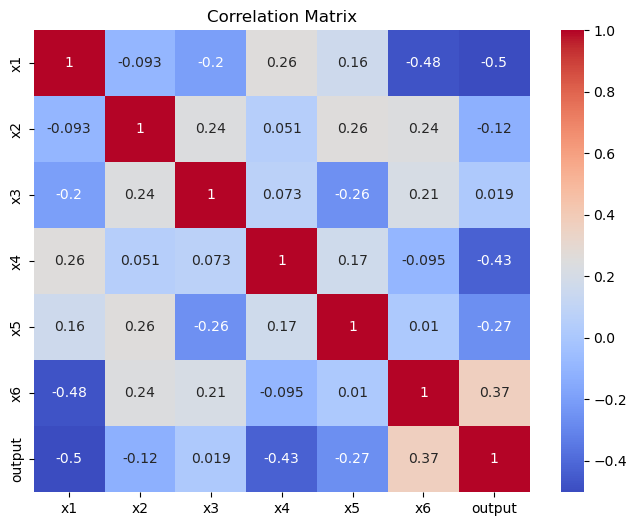

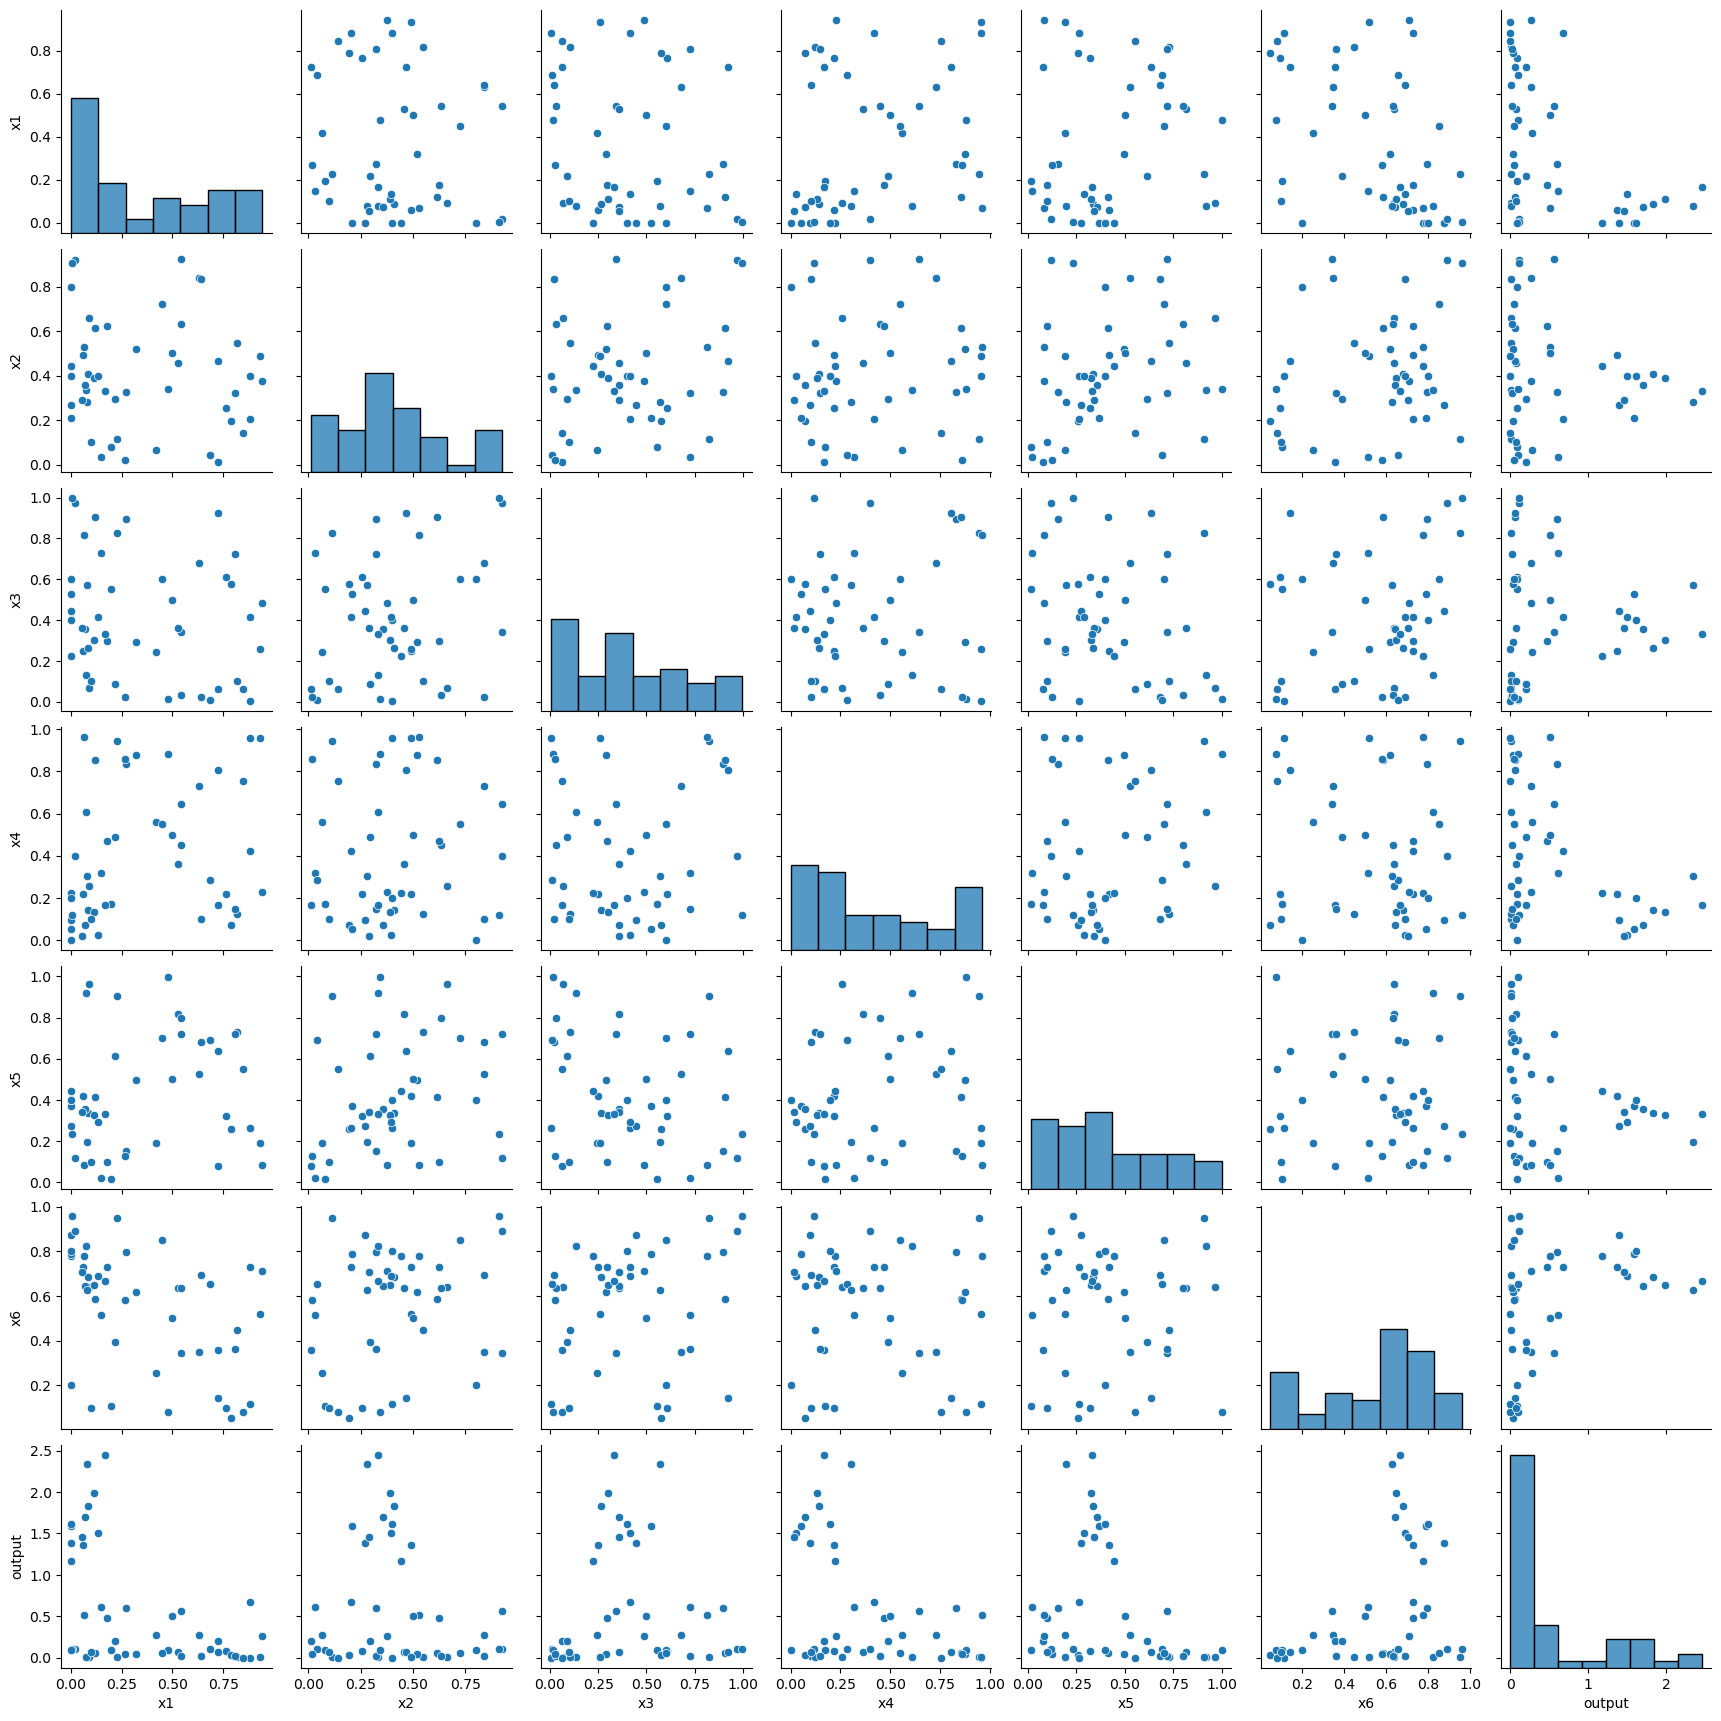

In [17]:
# Calculate correlations
correlations = df.corr()

# Plotting the correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplot to visualize relationships
sns.pairplot(df)
plt.show()

In [18]:
def compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi):
    """
    Compute kappa and xi values for each week in an optimization loop.

    Parameters:
    N_WEEKS: Number of weeks for the optimization loop.
    kappa_initial: Initial value of kappa.
    kappa_decay: Decay rate of kappa per week.
    min_kappa: Minimum value of kappa.
    xi_initial: Initial value of xi.
    xi_decay: Decay rate of xi per week.
    min_xi: Minimum value of xi.

    Returns:
    kappa_array: Array of kappa values for each week.
    xi_array: Array of xi values for each week.
    """

    kappa_array = np.zeros(N_WEEKS)
    xi_array = np.zeros(N_WEEKS)

    for week in range(N_WEEKS):
        kappa = max(kappa_initial * (kappa_decay ** week), min_kappa)
        xi = max(xi_initial * (xi_decay ** week), min_xi)
        kappa_array[week] = kappa
        xi_array[week] = xi

    return kappa_array, xi_array

# Example usage:
N_WEEKS = 10
kappa_initial = 1.96
kappa_decay = 0.9
min_kappa = 0.1
xi_initial = 0.1
xi_decay = 0.9
min_xi = 0.01

kappa_array, xi_array = compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi)
print("Kappa Array:", kappa_array)
print("Xi Array:", xi_array)

Kappa Array: [1.96       1.764      1.5876     1.42884    1.285956   1.1573604
 1.04162436 0.93746192 0.84371573 0.75934416]
Xi Array: [0.1        0.09       0.081      0.0729     0.06561    0.059049
 0.0531441  0.04782969 0.04304672 0.03874205]


In [19]:
#Evaluate Model Performance

def evaluate_model_performance(model, X_test, Y_test, model_type='sklearn'):
    """
    Evaluate the performance of a Gaussian Process model.

    Parameters:
    model: The trained Gaussian Process model.
    X_test: Test data features (numpy array).
    Y_test: True values for test data (numpy array).

    Returns:
    mse: Mean Squared Error of the model on the test data.
    r2: R-squared value indicating the proportion of variance explained by the model.
    """

    if model_type == 'gpy':
        y_pred, var_pred = model.predict(X_test)
        std_pred = np.sqrt(var_pred)
    elif model_type == 'sklearn':
        y_pred, std_pred = model.predict(X_test, return_std=True)

    # Ensure y_pred is 1D
    y_pred = y_pred.flatten()

    # Calculate residuals
    residuals = Y_test.flatten() - y_pred

    # Check if dimensions match
    if y_pred.shape != residuals.shape:
        raise ValueError(f"Shape mismatch: y_pred shape {y_pred.shape} and residuals shape {residuals.shape} must be the same.")        
        
    # Calculate MSE and R-squared
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")

    # Analyze residuals
    residuals = Y_test - y_pred

    # Plot residuals to look for patterns
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    return mse, r2

# Usage example:
# mse, r2 = evaluate_model_performance(best_gp, X_w1_new_points, Y_w1_new_points)
# print(f"MSE: {mse}")
# print(f"R-squared: {r2}")

In [20]:
# define multiple acquisition functions

#an acquisition function used in Bayesian optimization. 
# The EI is calculated for a set of points X, given a Gaussian process gp. It's used to determine the next point to sample.
def expected_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei


# Probability of Improvement acquisition function
def probability_of_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0

    return pi


# Define the UCB acquisition function
# After optimizing the hyperparameters, the Upper Confidence Bound (UCB) is used as the acquisition function in the weekly optimization loop. 
# The UCB balances exploration (trying new, uncertain points) and exploitation (focusing on points known to yield good results).
def upper_confidence_bound(X_grid, gp, kappa=1.96, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)

    return mu + kappa * sigma

In [21]:
# define grid based on dimensions

def generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points):
    """
    Generate a 2D grid of points for optimization.

    Parameters:
    domain_start_x1: Starting value of the first dimension.
    domain_end_x1: Ending value of the first dimension.
    domain_start_x2: Starting value of the second dimension.
    domain_end_x2: Ending value of the second dimension.
    num_points: Number of points to generate in each dimension.

    Returns:
    X_grid: A 2D numpy array of grid points.
    """

    # Generate arrays of evenly spaced values in each dimension
    x1 = np.linspace(domain_start_x1, domain_end_x1, num_points)
    x2 = np.linspace(domain_start_x2, domain_end_x2, num_points)

    # Use numpy's meshgrid function to create a grid efficiently
    X_grid = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)

    return X_grid
# Example usage:
# domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2 = 0.6, 0.65, 0.6, 0.65
# num_points = 100
# X_grid = generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points)

def generate_nd_grid(max_points, dimensions):
    # define range for input
	r_min, r_max = 0, 1.0

	# generate a random sample from the domain (dimensions)
	nd_grid = r_min + np.random.rand(max_points, dimensions) * (r_max - r_min)
	
	return np.array(nd_grid)

In [22]:
# propose the next points for all three acquisition functions

def propose_next_point(xi, kappa, X_grid, best_gp, model_type = 'sklearn'):
    """
    Update exploration-exploitation parameters and calculating next query points.
   
    Returns:
    Next query points for EI, PI, and UCB.
    """


    # EI next point calculation
    ei_values = expected_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_ei = np.argmax(ei_values)
    next_point_ei = X_grid[next_point_index_ei]
    print('Next query EI: ', format_query(next_point_ei, 6))

    # PI next point calculation
    pi_values = probability_of_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_pi = np.argmax(pi_values)
    next_point_pi = X_grid[next_point_index_pi]
    print('Next query PI: ', format_query(next_point_pi, 6))

    # UCB next point calculation
    ucb_value = upper_confidence_bound(X_grid, best_gp, kappa,model_type)
    next_point_index_ucb = np.argmax(ucb_value)
    next_point_ucb = X_grid[next_point_index_ucb]
    print('Next query UCB: ', format_query(next_point_ucb, 6))

    return next_point_ei, next_point_pi, next_point_ucb

# Approach 2: Surrogate - using sklearn GP model train accumulatively

In [28]:
#Approach 2 - modified
#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.
param_distributions = {
    'kernel__k1__constant_value': loguniform(1e-3, 1e3),
    'kernel__k2__length_scale': loguniform(1e-4, 1e2)
    #'k2__noise_level': loguniform(1e-3, 1e1)
}

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))  

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

random_search = RandomizedSearchCV(gp, param_distributions, n_iter=50, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_updated,Y_updated)

best_gp = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

print_timestamp()

Best Parameters: {'kernel__k1__constant_value': 0.0010792764548678455, 'kernel__k2__length_scale': 7.812113973534922}
Log-marginal-likelihood: -19.763993979125686
Current Timestamp:  2024-02-03 15:58:39.399478


## Appoach 2: using sklearn GP model via random generated grid

Next query EI:  0.927977-0.826523-0.042847-0.681527-0.291791-0.406643
Next query PI:  0.142892-0.308907-0.419014-0.236257-0.315303-0.670834
Next query UCB:  0.157452-0.217456-0.457728-0.312730-0.305861-0.675557
MSE: 5.212656537209867e-18
R-squared: 1.0


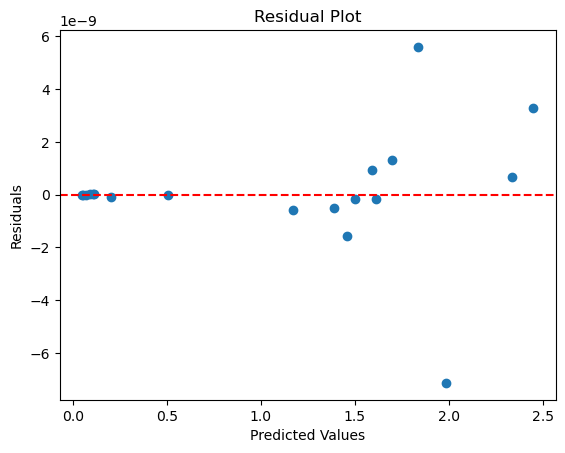

Current Timestamp:  2024-02-03 15:46:40.858848


In [24]:
#Approach 2: using sklearn GP model

# generate grid
max_points = 7000000 #9,000,000 (too big for memory)
dimensions = 6  # Change this to the desired number of dimensions
X_grid = []
X_grid = generate_nd_grid(max_points, dimensions)


# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 3  # For week 4, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid,best_gp,'sklearn')

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()

## Appoach 2: using sklearn GP model via Voronoi diagram generated grid

Next query EI:  0.028511-0.492758-0.424042-0.133378-0.267926-0.803415
Next query PI:  0.217936-0.299691-0.382456-0.197186-0.317470-0.711581
Next query UCB:  0.166990-0.254192-0.482724-0.247344-0.314109-0.659544
MSE: 5.212656537209867e-18
R-squared: 1.0


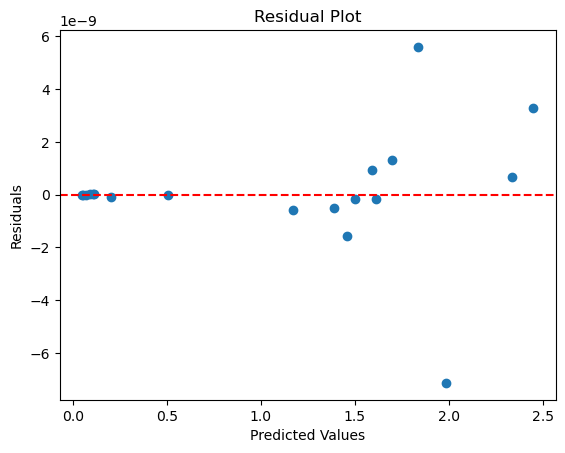

Current Timestamp:  2024-02-03 15:47:17.808917


In [25]:
# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 3  # For week 4, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,kde_samples_filtered,best_gp,'sklearn')

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()

## Aproach 3:  a Sparse Gaussian Process model

In [26]:
# Approach 3: gpy GP model

# Assuming X_w1 and Y_w1 are your data points
# Ensure X_w1 and Y_w1 are correctly shaped
# X_w1 = ... (your data, should be 2D, e.g., [n_samples, n_features])
# Y_w1 = ... (your data, should be 2D, e.g., [n_samples, 1])

# If Y_w1 is 1D, convert it to 2D
if Y_updated.ndim == 1:
    Y_updated_2d = Y_updated[:, np.newaxis]

# Create a kernel with RBF
kernel = GPy.kern.RBF(input_dim=X_updated.shape[1], variance=1., lengthscale=1.)

# Number of inducing points - this can be tuned based on your problem
num_inducing = 10  # This is an example value

# Creating a Sparse Gaussian Process Model
gp_sparse = GPy.models.SparseGPRegression(X_updated, Y_updated_2d, kernel, num_inducing=num_inducing)

# Model Optimization
gp_sparse.optimize(messages=True, optimizer='lbfgsb', max_iters=1000)

# Optionally, you can constrain parameters to be positive
gp_sparse.constrain_positive()

# After optimization, you can check the optimized hyperparameters
print("Optimized kernel parameters:", gp_sparse.kern)
print("Optimized noise variance:", gp_sparse.Gaussian_noise.variance)

# Evaluate model performance on a validation set, X_val and Y_val
Y_pred, Y_var = gp_sparse.predict(X_new_points)
mse = np.mean((Y_new_points - Y_pred)**2)
print("MSE on validation set:", mse)
print_timestamp()

reconstraining parameters sparse_gp


Optimized kernel parameters:   rbf.         |                value  |  constraints  |  priors
  variance     |  0.12050137803506192  |      +ve      |        
  lengthscale  |    0.435824464029105  |      +ve      |        
Optimized noise variance:   index  |  sparse_gp.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                         0.11365116  |      +ve      |        
MSE on validation set: 1.0999232888450903
Current Timestamp:  2024-02-03 15:47:26.488763


Next query EI:  0.130917-0.307370-0.445875-0.163333-0.261856-0.707704
Next query PI:  0.130917-0.307370-0.445875-0.163333-0.261856-0.707704
Next query UCB:  0.130917-0.307370-0.445875-0.163333-0.261856-0.707704
MSE: 0.10198672738383546
R-squared: 0.8539248270923723


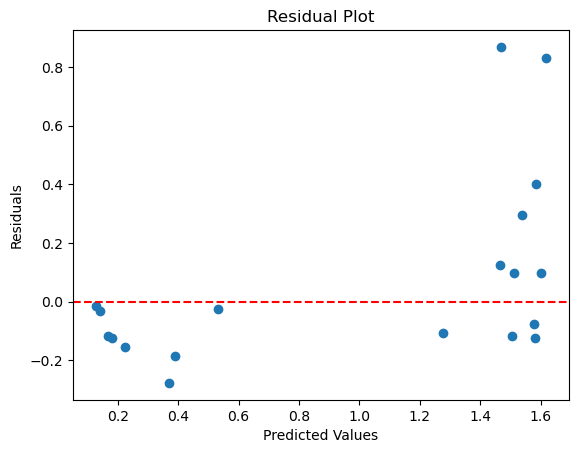

Current Timestamp:  2024-02-03 15:48:08.328456


In [27]:
# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid, gp_sparse,'gpy')

mse, r2 = evaluate_model_performance(gp_sparse, X_new_points, Y_new_points,'gpy')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

print_timestamp()

In [10]:
#Approach 2: using Randomized Hyperparameter Search for a Gaussian Process Regressor 
# and the implementation of several acquisition functions commonly used in Bayesian optimization: Expected Improvement (EI), Probability of Improvement (PI), and Upper Confidence Bound (UCB).
# and random search within a specified range

#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.
param_distributions = {
    'kernel__k1__constant_value': loguniform(1e-3, 1e3), #  the vertical scale of your function.
    'kernel__k2__length_scale': loguniform(1e-2, 1e2), # in the Radial-basis Function (RBF) kernel (also known as the Gaussian kernel) controls the horizontal length scale, i.e., how smooth or wiggly the function is.
    'alpha': loguniform(1e-10, 1e-2) # represents the noise level in the target variable. can help the model to account for noise in the observations.
}

# Define the kernel with initial parameters
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))  

# Create a Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20) # ontrols how many times the optimizer restarts, which is important for avoiding local optima in complex, multi-modal landscapes.

random_search = RandomizedSearchCV(gp, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X,Y)

best_gp = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

#an acquisition function used in Bayesian optimization. 
# The EI is calculated for a set of points X, given a Gaussian process gp. It's used to determine the next point to sample.

def expected_improvement(X, gp, xi=0.01):
    
    mu, sigma = gp.predict(X, return_std=True)
    mu_sample_opt = np.max(gp.predict(gp.X_train_)) # Finds the best (maximum) output observed so far from the training data of the Gaussian process.

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi # represents the improvement over mu_sample_opt that is expected for each point in X, adjusted by the trade-off parameter xi.
        Z = imp / sigma #is a standardized version of imp, which is used to calculate the probability and density values from the normal distribution.
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z) # Computes the expected improvement for each point in X, which includes both the expected improvement (imp) and the uncertainty (sigma) at that point.
        ei[sigma == 0.0] = 0.0

    return ei.flatten()

# Probability of Improvement acquisition function
def probability_of_improvement(X, gp, xi=0.01):
    
    mu, sigma = gp.predict(X, return_std=True)
    mu_sample_opt = np.max(gp.predict(gp.X_train_))
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0
    
    return pi.flatten()

# Define the UCB acquisition function
# After optimizing the hyperparameters, the Upper Confidence Bound (UCB) is used as the acquisition function in the weekly optimization loop. 
# The UCB balances exploration (trying new, uncertain points) and exploitation (focusing on points known to yield good results).
def upper_confidence_bound(X, gpr, kappa=1.96):
    
    mu, sigma = gpr.predict(X, return_std=True)
    return mu + kappa * sigma

def generate_nd_grid(max_points, dimensions):
    # define range for input
	r_min, r_max = 0, 1.0

	# generate a random sample from the domain (dimensions)
	nd_grid = r_min + np.random.rand(max_points, dimensions) * (r_max - r_min)
	
	return np.array(nd_grid)

# Kappa parameters for exploration-exploitation balance
#As the loop progresses, kappa decreases, gradually shifting the focus from exploring uncertain regions to exploiting regions known to yield better results.
kappa_initial = 1.96
kappa_decay = 0.9
min_kappa = 0.1
# Define xi parameters for exploration-exploitation balance
xi_initial = 0.1
xi_decay = 0.9
min_xi = 0.01


# Example usage:
max_points = 800000
dimensions = 6  # Change this to the desired number of dimensions
X_grid = []
X_grid = generate_nd_grid(max_points, dimensions)


# Define the number of weeks you plan to run this optimization
N_WEEKS = 10  # adjust this based on your requirement
# Weekly Optimization Loop
for week in range(N_WEEKS):
    # Decay kappa value exponentially for exploration-exploitation balance
    kappa = max(kappa_initial * (kappa_decay ** week), min_kappa)
    xi = max(xi_initial * (xi_decay ** week), min_xi)
    print(f"Week {week + 1}, kappa: {kappa}, xi: {xi}")

# EI next point calcuation
ei_values = expected_improvement(X_grid, best_gp,xi) # presumably the best Gaussian process model found via hyperparameter tuning (e.g., using RandomizedSearchCV)
next_point_index_ei = np.argmax(ei_values) # Finds the index of the maximum expected improvement in the grid.
next_point_ei = X_grid[next_point_index_ei] #considered the best candidate for the next function evaluation as it is expected to yield the most information gain according to the EI criterion.
print('Next query EI: ', format_query(next_point_ei,6))

# PI next point calcuation
pi_values = probability_of_improvement(X_grid, best_gp,xi)
# Select the point with the highest Probability of Improvement
next_point_index_pi = np.argmax(pi_values)
next_point_pi = X_grid[next_point_index_pi]
# Format the query point for printing, assuming the existence of a function 'format_query'
print('Next query PI: ', format_query(next_point_pi, 6))

# Select the point based on UCB using updated kappa
"""
Week 1, kappa: 1.96, xi: 0.1
Week 2, kappa: 1.764, xi: 0.09000000000000001
Week 3, kappa: 1.5876000000000001, xi: 0.08100000000000002
Week 4, kappa: 1.42884, xi: 0.0729
Week 5, kappa: 1.285956, xi: 0.06561
Week 6, kappa: 1.1573604000000002, xi: 0.05904900000000001
Week 7, kappa: 1.0416243600000001, xi: 0.05314410000000001
Week 8, kappa: 0.9374619240000002, xi: 0.04782969000000001
Week 9, kappa: 0.8437157316000001, xi: 0.04304672100000001
Week 10, kappa: 0.7593441584400001, xi: 0.03874204890000001
"""
ucb_value = upper_confidence_bound(X_grid, best_gp, kappa)
# Select the point with the highest UCB
next_point_index_ucb = np.argmax(ucb_value)
next_point_ucb = X_grid[next_point_index_ucb]
# Format the query point for printing, assuming the existence of a function 'format_query'
print('Next query UCB: ', format_query(next_point_ucb, 6))

Best Parameters: {'alpha': 0.0004566054873446117, 'kernel__k1__constant_value': 0.018794668241638453, 'kernel__k2__length_scale': 0.05337032762603955}
Log-marginal-likelihood: -7.327589075387859
Week 1, kappa: 1.96, xi: 0.1
Week 2, kappa: 1.764, xi: 0.09000000000000001
Week 3, kappa: 1.5876000000000001, xi: 0.08100000000000002
Week 4, kappa: 1.42884, xi: 0.0729
Week 5, kappa: 1.285956, xi: 0.06561
Week 6, kappa: 1.1573604000000002, xi: 0.05904900000000001
Week 7, kappa: 1.0416243600000001, xi: 0.05314410000000001
Week 8, kappa: 0.9374619240000002, xi: 0.04782969000000001
Week 9, kappa: 0.8437157316000001, xi: 0.04304672100000001
Week 10, kappa: 0.7593441584400001, xi: 0.03874204890000001
Next query EI:  0.018947-0.330595-0.300648-0.171993-0.419363-0.683676
Next query PI:  0.012832-0.394508-0.269662-0.245576-0.380203-0.736051
Next query UCB:  0.086339-0.408658-0.265295-0.141470-0.335118-0.683255


In [11]:
#Approach 2

#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.
param_distributions = {
    'kernel__k1__constant_value': loguniform(1e-3, 1e3), #  the vertical scale of your function.
    'kernel__k2__length_scale': loguniform(1e-2, 1e2), # in the Radial-basis Function (RBF) kernel (also known as the Gaussian kernel) controls the horizontal length scale, i.e., how smooth or wiggly the function is.
    'alpha': loguniform(1e-10, 1e-2) # represents the noise level in the target variable. can help the model to account for noise in the observations.
}

# Define the kernel with initial parameters
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))  

# Create a Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20) # ontrols how many times the optimizer restarts, which is important for avoiding local optima in complex, multi-modal landscapes.

random_search = RandomizedSearchCV(gp, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X,Y)

best_gp = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

#an acquisition function used in Bayesian optimization. 
# The EI is calculated for a set of points X, given a Gaussian process gp. It's used to determine the next point to sample.

def expected_improvement(X, gp, xi=0.01):
    X = np.atleast_2d(X)
    mu, sigma = gp.predict(X, return_std=True)
    mu_sample_opt = np.max(gp.predict(gp.X_train_)) # Finds the best (maximum) output observed so far from the training data of the Gaussian process.

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi # represents the improvement over mu_sample_opt that is expected for each point in X, adjusted by the trade-off parameter xi.
        Z = imp / sigma #is a standardized version of imp, which is used to calculate the probability and density values from the normal distribution.
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z) # Computes the expected improvement for each point in X, which includes both the expected improvement (imp) and the uncertainty (sigma) at that point.
        ei[sigma == 0.0] = 0.0

    return ei.flatten()

# Probability of Improvement acquisition function
def probability_of_improvement(X, gp, xi=0.01):
    X = np.atleast_2d(X)
    mu, sigma = gp.predict(X, return_std=True)
    mu_sample_opt = np.max(gp.predict(gp.X_train_))
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0
    
    return pi.flatten()

# Define the UCB acquisition function
# After optimizing the hyperparameters, the Upper Confidence Bound (UCB) is used as the acquisition function in the weekly optimization loop. 
# The UCB balances exploration (trying new, uncertain points) and exploitation (focusing on points known to yield good results).
def upper_confidence_bound(X, gpr, kappa=1.96):
    X = np.atleast_2d(X)
    mu, sigma = gpr.predict(X, return_std=True)
    return mu + kappa * sigma

def generate_nd_grid(max_points, dimensions):
    # Calculate the number of grid points along each dimension
    dim = int(max_points ** (1 / dimensions))

    # Create a list of linspace arrays for each dimension
    linspace_arrays = [np.linspace(0, 1, dim) for _ in range(dimensions)]

    # Create the n-dimensional grid using itertools.product
    nd_grid = list(itertools.product(*linspace_arrays))

    return np.array(nd_grid)

# Kappa parameters for exploration-exploitation balance
#As the loop progresses, kappa decreases, gradually shifting the focus from exploring uncertain regions to exploiting regions known to yield better results.
kappa_initial = 1.96
kappa_decay = 0.9
min_kappa = 0.1
# Define xi parameters for exploration-exploitation balance
xi_initial = 0.1
xi_decay = 0.9
min_xi = 0.01


# Example usage:
max_points = 100000
dimensions = 6  # Change this to the desired number of dimensions
X_grid = []
X_grid = generate_nd_grid(max_points, dimensions)


# Define the number of weeks you plan to run this optimization
N_WEEKS = 10  # adjust this based on your requirement
# Weekly Optimization Loop
for week in range(N_WEEKS):
    # Decay kappa value exponentially for exploration-exploitation balance
    kappa = max(kappa_initial * (kappa_decay ** week), min_kappa)
    xi = max(xi_initial * (xi_decay ** week), min_xi)
    print(f"Week {week + 1}, kappa: {kappa}, xi: {xi}")

# EI next point calcuation
ei_values = expected_improvement(X_grid, best_gp,xi) # presumably the best Gaussian process model found via hyperparameter tuning (e.g., using RandomizedSearchCV)
next_point_index_ei = np.argmax(ei_values) # Finds the index of the maximum expected improvement in the grid.
next_point_ei = X_grid[next_point_index_ei] #considered the best candidate for the next function evaluation as it is expected to yield the most information gain according to the EI criterion.
print('Next query EI: ', format_query(next_point_ei,6))

# PI next point calcuation
pi_values = probability_of_improvement(X_grid, best_gp,xi)
# Select the point with the highest Probability of Improvement
next_point_index_pi = np.argmax(pi_values)
next_point_pi = X_grid[next_point_index_pi]
# Format the query point for printing, assuming the existence of a function 'format_query'
print('Next query PI: ', format_query(next_point_pi, 6))

# Select the point based on UCB using updated kappa
"""
Week 1, kappa: 1.96, xi: 0.1
Week 2, kappa: 1.764, xi: 0.09000000000000001
Week 3, kappa: 1.5876000000000001, xi: 0.08100000000000002
Week 4, kappa: 1.42884, xi: 0.0729
Week 5, kappa: 1.285956, xi: 0.06561
Week 6, kappa: 1.1573604000000002, xi: 0.05904900000000001
Week 7, kappa: 1.0416243600000001, xi: 0.05314410000000001
Week 8, kappa: 0.9374619240000002, xi: 0.04782969000000001
Week 9, kappa: 0.8437157316000001, xi: 0.04304672100000001
Week 10, kappa: 0.7593441584400001, xi: 0.03874204890000001
"""
ucb_value = upper_confidence_bound(X_grid, best_gp, kappa)
# Select the point with the highest UCB
next_point_index_ucb = np.argmax(ucb_value)
next_point_ucb = X_grid[next_point_index_ucb]
# Format the query point for printing, assuming the existence of a function 'format_query'
print('Next query UCB: ', format_query(next_point_ucb, 6))

Best Parameters: {'alpha': 0.0004566054873446117, 'kernel__k1__constant_value': 0.018794668241638453, 'kernel__k2__length_scale': 0.05337032762603955}
Log-marginal-likelihood: -7.327589075387852
Week 1, kappa: 1.96, xi: 0.1
Week 2, kappa: 1.764, xi: 0.09000000000000001
Week 3, kappa: 1.5876000000000001, xi: 0.08100000000000002
Week 4, kappa: 1.42884, xi: 0.0729
Week 5, kappa: 1.285956, xi: 0.06561
Week 6, kappa: 1.1573604000000002, xi: 0.05904900000000001
Week 7, kappa: 1.0416243600000001, xi: 0.05314410000000001
Week 8, kappa: 0.9374619240000002, xi: 0.04782969000000001
Week 9, kappa: 0.8437157316000001, xi: 0.04304672100000001
Week 10, kappa: 0.7593441584400001, xi: 0.03874204890000001
Next query EI:  0.000000-0.400000-0.400000-0.200000-0.400000-0.800000
Next query PI:  0.000000-0.400000-0.200000-0.200000-0.400000-0.800000
Next query UCB:  0.000000-0.400000-0.400000-0.200000-0.400000-0.800000


In [10]:
%matplotlib inline

bounds = np.array([[0, 1]] * 6)  # Adjust according to your problem's constraints
noise = 0.2

X_init = X
Y_init = Y

print(X_init.shape[0])
print(X_init.shape[0])

30
30


In [11]:
# implement the acquision function

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [12]:
# a function that proposes the next sampling point by computing the location of the acquisition function maximum. Optimization is restarted n_restarts times to avoid local optima.

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

In [10]:
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition
from scipy.stats import norm  # Import the 'norm' function

# Gaussian process with Matérn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10



# Placeholder function to submit your query and receive the output
def submit_query_and_receive_output(X):
    # This function should submit the query X and return the received output
    # Implement the submission mechanism here
    # For now, it returns a random number as a placeholder
    return np.random.rand()  # Replace with actual submission and receiving mechanism

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    X_next = X_next.reshape(1, -1)
    
    # Obtain next noisy sample from the objective function
    Y_next = submit_query_and_receive_output(X_next)
    
    
    # Add the new sample to our existing samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.append(Y_sample, Y_next)
    
    # Optionally, print or log the submitted query
    formatted_query = [format_query(x,6) for x in X_next]
    print(f"Week {i + 1}, Submitted Query: {formatted_query}")    
    #print(X_next)

NameError: name 'noise' is not defined

In [15]:
#import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

# Non-linear data
x_nonlinear = X
y_nonlinear = Y


# Perform polynomial extrapolation (quadratic)
# Fit a quadratic model (degree 2 polynomial)
poly_model = Polynomial.fit(x_nonlinear, y_nonlinear, 2)

# Predict future values
x_future_nonlinear = np.linspace(10, 15, 10)
y_future_nonlinear = poly_model(x_future_nonlinear)

# Plotting the results
plt.figure(figsize=(12, 6))

# Polynomial Extrapolation Plot
plt.subplot(1, 2, 2)
plt.plot(x_nonlinear, y_nonlinear, 'go-', label='Original Data (Non-Linear)')
plt.plot(x_future_nonlinear, y_future_nonlinear, 'mo-', label='Extrapolated Data')
plt.title('Polynomial Extrapolation')
plt.legend()

plt.tight_layout()
plt.show()


ValueError: Coefficient array is not 1-d

In [ ]:
new_data_predictions = final_model.predict(new_data)
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'test_data' is your test dataset and 'true_labels' are the actual target values
test_predictions = final_model.predict(test_data)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_labels, test_predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_labels, test_predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

"""Replace test_data and true_labels with your test dataset and its corresponding actual target values.

Interpretation:

Lower MAE, MSE, and RMSE values indicate better model performance.
You can also visualize the predicted vs. actual values using scatter plots or other relevant visualization techniques to get a better understanding of how well your model is performing.
These steps will allow you to use your final Random Forest Regressor model to make predictions on new data and evaluate its performance on a test dataset."""